<a href="https://colab.research.google.com/github/DeAnd02/RepieceViT/blob/main/repiece_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model

## Imports

In [15]:
import math, time, random, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

## Parameters configuration

In [16]:
IMG, PATCH = 96, 32               # image size, patch size
ROWS = COLS = IMG // PATCH
P = ROWS * COLS

D_MODEL, N_HEADS, N_LAYERS = 200, 5, 6   # modello più piccolo
DROPOUT = 0.1
BATCH,  EPOCHS = 256, 150
LR,     WD     = 3e-4, 0.05         # Learning rate, weight decay
LABEL_SMOOTH   = 0.05               #
PATIENCE, DELTA = 5, 1e-3           # Patience: number of epochs for early stopping

DEV = "cuda" if torch.cuda.is_available() else "cpu"
AMP = torch.cuda.is_available()

plain_tf = transforms.ToTensor()

## Dataset and Patches

In [17]:
class STL10Jigsaw(Dataset):
    def __init__(self, split, tf):
        # Load STL10 dataset with specified split and transform
        self.ds = datasets.STL10("./data", split=split,
                                 download=True, transform=tf)

    def __len__(self):
        # Return total number of samples
        return len(self.ds)

    def _patchify(self, img):
      # Split image into non-overlapping PATCH x PATCH patches
        p = img.unfold(1, PATCH, PATCH).unfold(2, PATCH, PATCH) # DIM: (3, n_patches_H, PATCH, n_patches_W, PATCH)
        return p.permute(1,2,0,3,4).contiguous().view(-1,3,PATCH,PATCH) # (n_patches_H, n_patches_W, 3, PATCH, PATCH)

    def __getitem__(self, idx):
        img, _  = self.ds[idx]                  # Get image from dataset
        patches = self._patchify(img)           # Divide image into patches
        perm    = torch.randperm(P)             # Generate random permutation
        return patches[perm], perm, patches     # Return shuffled, label, original

# Load full STL10 dataset using the 'unlabeled' split and a plain transform
full_train = STL10Jigsaw("unlabeled", plain_tf)

# Use 10% of the dataset for validation
val_len = int(0.1 * len(full_train))

# Split into training and validation sets, fixed random seed for reproducibility
train_ds, val_ds = random_split(
    full_train,
    [len(full_train) - val_len, val_len],
    generator=torch.Generator().manual_seed(42)
)

# DataLoader for training: shuffle enabled for better generalization across epochs
train_ld = DataLoader(train_ds, batch_size=BATCH, shuffle=True,
                      num_workers=2, pin_memory=True)

# DataLoader for validation: no shuffle to keep metrics consistent
val_ld = DataLoader(val_ds, batch_size=BATCH, shuffle=False,
                    num_workers=2, pin_memory=True)


class PatchEmbed(nn.Module):
    def __init__(self):
        super().__init__()
        # Linear layer to project each flattened patch to D_MODEL dimension (embeddings)
        self.fc = nn.Linear(3 * PATCH * PATCH, D_MODEL)

    def forward(self, x):                       # Input shape: (B, P, 3, p, p)
        B, P, C, ph, pw = x.shape
        # Flatten each patch and apply linear projection
        return self.fc(x.view(B, P, -1))        # Output: (B, P, D_MODEL)

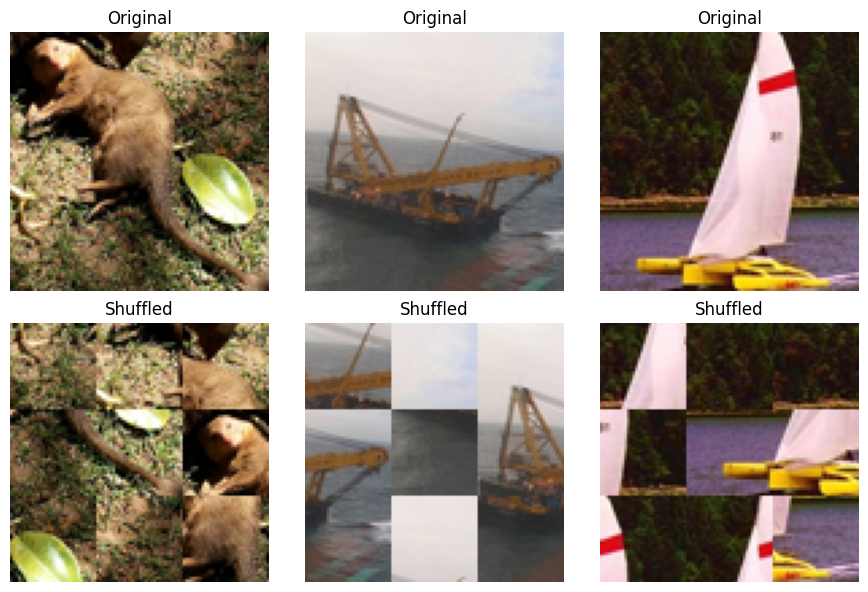

In [18]:
import math, random
import torch
import matplotlib.pyplot as plt

def compose(patches, perm):
    """
    Riordina il tensor di patch 'patches' (shape: P×C×ph×pw)
    secondo l'indice 'perm' (torch.LongTensor di lunghezza P),
    e le ricompone in un'unica immagine.
    """
    ordered = patches[perm]
    P, C, ph, pw = ordered.shape
    grid_size = int(math.sqrt(P))  # es. P=9 → grid_size=3

    # costruisci ogni riga concatenando orizzontalmente
    rows = []
    for r in range(grid_size):
        row_patches = [ordered[r*grid_size + c] for c in range(grid_size)]
        rows.append(torch.cat(row_patches, dim=2))  # concatenazione sui pixel orizzontali

    # concatena le righe verticalmente
    return torch.cat(rows, dim=1)  # shape: C×(ph·grid_size)×(pw·grid_size)

def show_grid(ds, num_cols=3):
    """
    ds: dataset che restituisce (puzzle, perm, orig_patches)
    num_cols: numero di colonne della griglia
    """
    # scegli num_cols esempi distinti
    indices = random.sample(range(len(ds)), num_cols)

    fig, axes = plt.subplots(2, num_cols, figsize=(num_cols*3, 6))

    for i, idx in enumerate(indices):
        puzzle, perm, orig_patches = ds[idx]  # :contentReference[oaicite:0]{index=0}

        # --- Original ---
        img_orig = compose(orig_patches, torch.arange(orig_patches.size(0)))
        axes[0, i].imshow(img_orig.permute(1, 2, 0))
        axes[0, i].axis('off')

        axes[0, i].set_title("Original")

        # --- Shuffled ---
        img_shuf = compose(puzzle, torch.arange(puzzle.size(0)))
        axes[1, i].imshow(img_shuf.permute(1, 2, 0))
        axes[1, i].axis('off')

        axes[1, i].set_title("Shuffled")

    plt.tight_layout()
    plt.show()

# Chiamata di esempio
show_grid(val_ds, num_cols=3)


## Model Structure

In [19]:
class ViT_Puzzle(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = PatchEmbed()  # Embed each image patch into a D_MODEL-dim vector
        self.pos   = nn.Parameter(torch.randn(1, P, D_MODEL))  # Learnable positional embeddings

        # Define a single transformer encoder layer
        enc_layer  = nn.TransformerEncoderLayer(
            D_MODEL,
            N_HEADS,
            dim_feedforward=D_MODEL * 4,      # *4 is a good compromise between performance and computational cost ("Attention is all you need")
            dropout=DROPOUT,
            batch_first=True
        )

        # Stack multiple encoder layers
        self.enc  = nn.TransformerEncoder(enc_layer, N_LAYERS)

        # Classification head: predicts the position index for each patch
        self.head = nn.Linear(D_MODEL, P)

    def forward(self, patches):
        x = self.embed(patches) + self.pos     # Add positional embeddings
        x = self.enc(x)                         # Apply transformer encoder
        return self.head(x)                     # Output shape: (B, P, P)

# Initialize model and optimizer
net   = ViT_Puzzle().to(DEV)
opt   = torch.optim.AdamW(net.parameters(), lr=LR, weight_decay=WD)

#
sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=10)

# Mixed precision training scaler, to use different precision of float operation
scaler = torch.amp.GradScaler(enabled=AMP)

# Cross-entropy loss with label smoothing (helps regularize and prevent overconfidence)
ce_smooth = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)

# Example: commonly used smoothing values are 0.05 or 0.1.
# The true label gets (value - LABEL_SMOOTH) probability, while the remaining (LABEL_SMOOTH/NUM_classes) is distributed among other classes.

# logits shape: (B, P, P): predictions for each of the P patches over P possible positions
# labels shape: (B, P): true positions for each patch
def loss_fn(logits, labels):
    return ce_smooth(logits.transpose(1, 2), labels)  # transpose for correct shape: (B, C, N)

######## NOTA PER NOI: potrebbe essere inutile il transpose perchè P e P sono uguali: (B, P, P) = (B, P, P)

# Training

In [ ]:
best_val = math.inf        # Best validation loss seen so far
epochs_bad = 0             # Counter for early stopping

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    # --- Training phase ---
    net.train()
    train_loss = 0
    for puzzle, perm, _ in train_ld:
        puzzle, perm = puzzle.to(DEV), perm.to(DEV)
        opt.zero_grad(set_to_none=True)  # Clear gradients

        # Forward pass with mixed precision
        with torch.amp.autocast(device_type='cuda', enabled=AMP):
            loss = loss_fn(net(puzzle), perm)

        # Backward pass and optimizer step
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        train_loss += loss.item()
    train_loss /= len(train_ld)

    # --- Validation phase ---
    net.eval()
    val_loss = 0
    with torch.no_grad(), torch.amp.autocast(device_type='cuda', enabled=AMP):
        for puzzle, perm, _ in val_ld:
            val_loss += loss_fn(net(puzzle.to(DEV)), perm.to(DEV)).item()
    val_loss /= len(val_ld)

    #
    sched.step()

    print(f"Ep {epoch:03}  train {train_loss:.3f}  val {val_loss:.3f}  "
          f"lr {sched.get_last_lr()[0]:.1e}  {(time.time()-t0):.1f}s")

    # Print progress for the epoch
    """print(f"Ep {epoch:03}  train {train_loss:.3f}  val {val_loss:.3f}  "
          f"{(time.time()-t0):.1f}s")"""

    # --- Early stopping ---
    if val_loss < best_val - DELTA:
        best_val = val_loss
        epochs_bad = 0
        torch.save(net.state_dict(), "best_vit_jigsaw.pt")  # Save best model
    else:
        epochs_bad += 1
        if epochs_bad >= PATIENCE:
            print("Early-stop.")
            break

Ep 001  train 1.964  val 1.642  lr 2.9e-04  71.5s
Ep 002  train 1.516  val 1.358  lr 2.7e-04  67.5s
Ep 003  train 1.309  val 1.161  lr 2.4e-04  73.7s
Ep 004  train 1.138  val 0.989  lr 2.0e-04  75.0s
Ep 005  train 0.992  val 0.851  lr 1.5e-04  66.6s
Ep 006  train 0.875  val 0.751  lr 1.0e-04  70.7s
Ep 007  train 0.789  val 0.664  lr 6.2e-05  72.4s
Ep 008  train 0.734  val 0.632  lr 2.9e-05  67.9s
Ep 009  train 0.698  val 0.609  lr 7.3e-06  74.0s
Ep 010  train 0.682  val 0.602  lr 3.0e-04  70.0s


## Model Saving

In [ ]:
torch.save(net.state_dict(), "best_vit_jigsawSTL.pt")

## Model Loading

In [ ]:
net.load_state_dict(torch.load("best_vit_jigsaw.pt"))
net.eval()

# Test Phase

## Hungarian perm

In [ ]:
@torch.no_grad()
def hungarian_perm(logits_2d):
    # logits_2d: (P, P): prediction scores for assigning P patches to P positions

    # Apply the Hungarian algorithm to maximize total score
    # We negate logits since linear_sum_assignment minimizes the cost
    row, col = linear_sum_assignment(-logits_2d.cpu().numpy())

    # Return the optimal column indices as a tensor (predicted permutation)
    return torch.tensor(col)

## Utility functions

In [ ]:
def compose(patches, perm):
    # Reorder patches according to permutation
    ordered = patches[perm]

    # Concatenate patches row by row
    rows = [torch.cat([ordered[r * COLS + c] for c in range(COLS)], dim=2)
            for r in range(ROWS)]

    # Combine all rows into a full image
    return torch.cat(rows, dim=1)        #shape: (3, 96, 96)


@torch.no_grad()
def invert_permutation(p):
    # Create an inverse permutation such that inv[p[i]] = i
    inv = torch.empty_like(p)
    inv[p] = torch.arange(len(p))
    return inv


@torch.no_grad()
def show_example(ds, idx=None):
    if idx is None:
        idx = random.randint(0, len(ds) - 1)  # Pick random index if not provided

    # Retrieve data from dataset
    puzzle, gt_perm, orig = ds[idx]

    # Model prediction
    logits = net(puzzle.unsqueeze(0).to(DEV))[0]         # Add batch dim and forward pass
    pred_perm = hungarian_perm(logits)                   # Get predicted permutation

    # Print permutations
    print(f"Permutation GT       : {gt_perm.tolist()}")
    print(f"Permutation Predicted: {pred_perm.tolist()}")

    # Reconstruct images for visualization
    img_gt    = compose(orig, torch.arange(P))                 # Ground truth image
    img_input = compose(puzzle, torch.arange(P))               # Scrambled input puzzle
    img_pred  = compose(puzzle, invert_permutation(pred_perm)) # Model reconstruction

    # Display original, input, and predicted images
    fig, ax = plt.subplots(1, 3, figsize=(6, 2))
    ax[0].imshow(img_gt.permute(1, 2, 0));     ax[0].set_title("Correct");    ax[0].axis("off")
    ax[1].imshow(img_input.permute(1, 2, 0));  ax[1].set_title("Input");      ax[1].axis("off")
    ax[2].imshow(img_pred.permute(1, 2, 0));   ax[2].set_title("Predicted");  ax[2].axis("off")
    plt.show()


## Examples

In [ ]:
show_example(val_ds)
show_example(val_ds)

## Validation accuracy


In [ ]:
from scipy.optimize import linear_sum_assignment

@torch.no_grad()
def compute_validation_accuracy(model, val_loader):
    model.eval()  # Set model to evaluation mode
    total_patches = 0
    correct_patches = 0

    for puzzle, true_perm, _ in val_loader:
        puzzle = puzzle.to(DEV)
        true_perm = true_perm.to(DEV)

        logits = model(puzzle)  # Output shape: (B, P, P): score matrix for each image
        B, P, _ = logits.shape

        for b in range(B):
            logit = logits[b]  # (P, P) matrix for image b

            # Apply Hungarian algorithm to find optimal patch assignment
            row, col = linear_sum_assignment(-logit.cpu().numpy())

            # Convert predicted permutation to tensor and move to device
            pred_perm = torch.tensor(col, device=DEV)

            # Compare predicted permutation with ground truth
            correct = (pred_perm == true_perm[b]).sum().item()
            correct_patches += correct
            total_patches += P

    # Compute overall accuracy as fraction of correctly placed patches
    accuracy = correct_patches / total_patches
    return accuracy

# Compute and print validation accuracy
acc = compute_validation_accuracy(net, val_ld)
print(f"Validation accuracy: {acc * 100:.2f}%")

# Test on CIFAR10 Dataset

In [ ]:
import math, time, random, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

##PARAMETERS CONFIGURATION

In [ ]:
IMG, PATCH = 96, 32               # image size, patch size
ROWS = COLS = IMG // PATCH
P = ROWS * COLS

D_MODEL, N_HEADS, N_LAYERS = 200, 5, 6   # modello più piccolo
DROPOUT = 0.1
BATCH,  EPOCHS = 256, 150
LR,     WD     = 3e-4, 0.05         # Learning rate, weight decay
LABEL_SMOOTH   = 0.05               #
PATIENCE, DELTA = 5, 1e-3           # Patience: number of epochs for early stopping

DEV = "cuda" if torch.cuda.is_available() else "cpu"
AMP = torch.cuda.is_available()

plain_tf = transforms.ToTensor()

In [ ]:
# Resize images to bigger size, more difficult task than in the previous dataset
plain_tf = transforms.Compose([
    transforms.Resize((96, 96)),  # Resize image to 96x96 pixels
    transforms.ToTensor()        # Convert image to PyTorch tensor with values normalized in [0, 1]
])

## Dataset and patches

In [ ]:
class CIFAR10Jigsaw(Dataset):
    def __init__(self, split, tf):
        # Load CIFAR-10 dataset with given split ("train" or "test") and transform
        is_train = (split == "train")
        self.ds = CIFAR10("./data", train=is_train, download=True, transform=tf)

    def __len__(self):
        # Return total number of samples
        return len(self.ds)

    def _patchify(self, img):
        # img shape: (3, 96, 96): divide into non-overlapping (3, 32, 32) patches
        p = img.unfold(1, PATCH, PATCH).unfold(2, PATCH, PATCH)
        return p.permute(1, 2, 0, 3, 4).contiguous().view(-1, 3, PATCH, PATCH)

    def __getitem__(self, idx):
        img, _ = self.ds[idx]              # Get image (labels not needed)
        patches = self._patchify(img)      # Divide image into patches
        perm = torch.randperm(P)           # Generate a random permutation of patch indices
        return patches[perm], perm, patches  # Return shuffled patches, true permutation, original patches

# Load full CIFAR10 dataset using the 'train' split and a plain transform
full_train = CIFAR10Jigsaw("train", plain_tf)

# Use 10% of the dataset for validation
val_len = int(0.1 * len(full_train))

# Split into training and validation sets, fixed random seed for reproducibility
train_ds, val_ds = random_split(
    full_train,
    [len(full_train) - val_len, val_len],
    generator=torch.Generator().manual_seed(42)
)

# DataLoader for training: shuffle enabled for better generalization across epochs
train_ld = DataLoader(train_ds, batch_size=BATCH, shuffle=True,
                      num_workers=2, pin_memory=True)

# DataLoader for validation: no shuffle to keep metrics consistent
val_ld = DataLoader(val_ds, batch_size=BATCH, shuffle=False,
                    num_workers=2, pin_memory=True)



class PatchEmbed(nn.Module):
    def __init__(self):
        super().__init__()
        # Linear layer to project each flattened patch to D_MODEL dimension (embeddings)
        self.fc = nn.Linear(3 * PATCH * PATCH, D_MODEL)

    def forward(self, x):                       # Input shape: (B, P, 3, p, p)
        B, P, C, ph, pw = x.shape
        # Flatten each patch and apply linear projection
        return self.fc(x.view(B, P, -1))        # Output: (B, P, D_MODEL)

## Model Structure

In [ ]:
class ViT_Puzzle(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = PatchEmbed()  # Embed each image patch into a D_MODEL-dim vector
        self.pos   = nn.Parameter(torch.randn(1, P, D_MODEL))  # Learnable positional embeddings

        # Define a single transformer encoder layer
        enc_layer  = nn.TransformerEncoderLayer(
            D_MODEL,
            N_HEADS,
            dim_feedforward=D_MODEL * 4,      # *4 is a good compromise between performance and computational cost ("Attention is all you need")
            dropout=DROPOUT,
            batch_first=True
        )

        # Stack multiple encoder layers
        self.enc  = nn.TransformerEncoder(enc_layer, N_LAYERS)

        # Classification head: predicts the position index for each patch
        self.head = nn.Linear(D_MODEL, P)

    def forward(self, patches):
        x = self.embed(patches) + self.pos     # Add positional embeddings
        x = self.enc(x)                         # Apply transformer encoder
        return self.head(x)                     # Output shape: (B, P, P)

# Initialize model and optimizer
net   = ViT_Puzzle().to(DEV)
opt   = torch.optim.AdamW(net.parameters(), lr=LR, weight_decay=WD)

# Mixed precision training scaler, to use different precision of float operation
scaler = torch.amp.GradScaler(enabled=AMP)

# Cross-entropy loss with label smoothing (helps regularize and prevent overconfidence)
ce_smooth = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)

# Example: commonly used smoothing values are 0.05 or 0.1.
# The true label gets (value - LABEL_SMOOTH) probability, while the remaining (LABEL_SMOOTH/NUM_classes) is distributed among other classes.

# logits shape: (B, P, P) → predictions for each of the P patches over P possible positions
# labels shape: (B, P) → true positions for each patch
def loss_fn(logits, labels):
    return ce_smooth(logits.transpose(1, 2), labels)  # transpose for correct shape: (B, C, N)

######## NOTA PER NOI: potrebbe essere inutile il transpose perchè P e P sono uguali: (B, P, P) = (B, P, P)

## Training

In [ ]:
best_val = math.inf        # Best validation loss seen so far
epochs_bad = 0             # Counter for early stopping

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    # --- Training phase ---
    net.train()
    train_loss = 0
    for puzzle, perm, _ in train_ld:
        puzzle, perm = puzzle.to(DEV), perm.to(DEV)
        opt.zero_grad(set_to_none=True)  # Clear gradients

        # Forward pass with mixed precision
        with torch.amp.autocast(device_type='cuda', enabled=AMP):
            loss = loss_fn(net(puzzle), perm)

        # Backward pass and optimizer step
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        train_loss += loss.item()
    train_loss /= len(train_ld)

    # --- Validation phase ---
    net.eval()
    val_loss = 0
    with torch.no_grad(), torch.amp.autocast(device_type='cuda', enabled=AMP):
        for puzzle, perm, _ in val_ld:
            val_loss += loss_fn(net(puzzle.to(DEV)), perm.to(DEV)).item()
    val_loss /= len(val_ld)

    # Print progress for the epoch
    print(f"Ep {epoch:03}  train {train_loss:.3f}  val {val_loss:.3f}  "
          f"{(time.time()-t0):.1f}s")

    # --- Early stopping ---
    if val_loss < best_val - DELTA:
        best_val = val_loss
        epochs_bad = 0
        torch.save(net.state_dict(), "best_vit_jigsaw.pt")  # Save best model
    else:
        epochs_bad += 1
        if epochs_bad >= PATIENCE:
            print("Early-stop.")
            break

Ep 001  train 2.205  val 2.176  32.4s
Ep 002  train 1.994  val 1.716  32.5s
Ep 003  train 1.587  val 1.415  32.3s
Ep 004  train 1.364  val 1.186  33.1s
Ep 005  train 1.180  val 0.989  33.8s
Ep 006  train 1.008  val 0.789  32.1s
Ep 007  train 0.838  val 0.622  32.8s
Ep 008  train 0.693  val 0.564  31.8s
Ep 009  train 0.584  val 0.412  32.8s
Ep 010  train 0.495  val 0.361  31.6s
Ep 011  train 0.436  val 0.306  32.7s
Ep 012  train 0.377  val 0.257  31.8s
Ep 013  train 0.345  val 0.224  32.5s
Ep 014  train 0.313  val 0.212  32.3s
Ep 015  train 0.276  val 0.186  32.1s
Ep 016  train 0.265  val 0.194  32.7s
Ep 017  train 0.237  val 0.149  31.9s
Ep 018  train 0.212  val 0.154  32.8s
Ep 019  train 0.211  val 0.145  31.7s
Ep 020  train 0.191  val 0.141  32.9s
Ep 021  train 0.183  val 0.132  31.9s
Ep 022  train 0.173  val 0.126  32.9s
Ep 023  train 0.170  val 0.122  31.7s
Ep 024  train 0.153  val 0.110  32.7s
Ep 025  train 0.149  val 0.149  31.7s
Ep 026  train 0.144  val 0.115  32.9s
Ep 027  trai

## Model Saving

In [ ]:
torch.save(net.state_dict(), "best_vit_jigsaw.pt")

## Model Loading

In [ ]:
net.load_state_dict(torch.load("best_vit_jigsaw.pt"))
net.eval()

ViT_Puzzle(
  (embed): PatchEmbed(
    (fc): Linear(in_features=3072, out_features=200, bias=True)
  )
  (enc): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=200, out_features=200, bias=True)
        )
        (linear1): Linear(in_features=200, out_features=800, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=800, out_features=200, bias=True)
        (norm1): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (head): Linear(in_features=200, out_features=9, bias=True)
)

In [ ]:
# Load full CIFAR-10 training dataset with patch-based jigsaw transformation
full_train = CIFAR10Jigsaw("train", plain_tf)

# Reserve 10% of the data for validation
val_len = int(0.1 * len(full_train))

# Split dataset into training and validation subsets with fixed random seed for reproducibility
train_ds, val_ds = random_split(
    full_train,
    [len(full_train) - val_len, val_len],
    generator=torch.Generator().manual_seed(42)
)

# Create DataLoader for training: shuffling enabled, better generalization
train_ld = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True)

# Create DataLoader for validation: no shuffling to maintain consistency
val_ld = DataLoader(val_ds, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
net.load_state_dict(torch.load("/content/best_vit_jigsaw.pt"))
net.eval()

## Examples

In [ ]:
show_example(val_ds)
show_example(val_ds)

## Validation accuracy

In [ ]:
from scipy.optimize import linear_sum_assignment

@torch.no_grad()
def compute_validation_accuracy(model, val_loader):
    model.eval()  # Set model to evaluation mode
    total_patches = 0
    correct_patches = 0

    for puzzle, true_perm, _ in val_loader:
        puzzle = puzzle.to(DEV)
        true_perm = true_perm.to(DEV)

        logits = model(puzzle)  # Output shape: (B, P, P): score matrix for each image
        B, P, _ = logits.shape

        for b in range(B):
            logit = logits[b]  # (P, P) matrix for image b

            # Apply Hungarian algorithm to find optimal patch assignment
            row, col = linear_sum_assignment(-logit.cpu().numpy())

            # Convert predicted permutation to tensor and move to device
            pred_perm = torch.tensor(col, device=DEV)

            # Compare predicted permutation with ground truth
            correct = (pred_perm == true_perm[b]).sum().item()
            correct_patches += correct
            total_patches += P

    # Compute overall accuracy as fraction of correctly placed patches
    accuracy = correct_patches / total_patches
    return accuracy

acc = compute_validation_accuracy(net, val_ld)
print(f"Validation accuracy: {acc * 100:.2f}%")

Validation accuracy: 97.73%
